# Exploring the LogosInTheWild dataset #


In [65]:
import numpy as np
import cv2
import csv
import matplotlib.pyplot as plt
import pickle
import pandas
from PIL import Image
%matplotlib inline


## Utility functions ##

In [67]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3, draw_dot=False, radius=7):
    ''' 
    This function draws out the bounding boxes for objects in the image as
    specified by the csv file
    '''
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
        if draw_dot:
            centre = (np.array(bbox[0]) + np.array(bbox[1])) // 2
            cv2.circle(draw_img, tuple(centre), radius=radius, color=(0, 255, 0), thickness=-1)
    # Return the image copy with boxes drawn
    return draw_img

def draw_grid(img, grid=11, thick=3):
    '''
    Visualize gridcells over the given image
    '''
    x, y = img.shape[1], img.shape[0]
    x_inc, y_inc = x//grid, y//grid
    
    for a in range(grid):
        cv2.line(img, (a*x_inc, 0), (a*x_inc, y), color=(255,0,0), thickness=thick)
    for b in range(grid):
        cv2.line(img, (0, b*y_inc), (x, b*y_inc), color=(255,0,0), thickness=thick)
    return img

def frame_dict(labels_rows, scalex=1, scaley=1):
    frames = {}
    for row in labels_rows :
        if str(row[4]) not in frames:
            frames[str(row[4])] = []
        frames[str(row[4])].append( ( 
            ((int(int(row[0])//scalex), int(int(row[1])//scaley)) , (int(int(row[2])//scalex), int(int(row[3])//scaley)))  ,  
            (int(row[5]=='coca-cola'), int(row[5]=='red bull'), int(row[5]=='heineken')) 
        ) )
    return frames

def label_to_tensor(frame, imgsize=(224, 224), gridsize=(11,11), classes=3, bboxes=1):
    '''
    label_to_tensor() function takes in a frame label info from the dataset and 
    returns an array of shape SS(C+5B): [ClassProb--Confidence--x/y/w/h]
    Confidence is set to zero as it needs to be calculated at training time for each BBox predicted by the classifier
    '''
    grid = np.zeros(gridsize)
    
    y_span = imgsize[0]/gridsize[0]
    x_span = imgsize[1]/gridsize[1]
    
    class_prob = np.zeros((gridsize[0], gridsize[1], classes))
    confidence = np.zeros((gridsize[0], gridsize[1], bboxes))
    dims = np.zeros((gridsize[0], gridsize[1], bboxes, 4))
    
    for box in frame:
        ((x1,y1), (x2,y2)), (c1,c2,c3) = box
        x_grid = int(((x1+x2)/2)//x_span)
        y_grid = int(((y1+y2)/2)//y_span)
        
        class_prob[y_grid, x_grid] = (c1,c2,c3)
        
        x_center = ((x1+x2)/2)
        y_center = ((y1+y2)/2)
        
        x_center_norm = (x_center-x_grid*x_span)/(x_span)
        y_center_norm = (y_center-y_grid*y_span)/(y_span)
        
        w = x2-x1
        h = y2-y1
        
        w_norm = w/imgsize[1]
        h_norm = h/imgsize[0]
        
        dims[y_grid, x_grid, :, :] = (x_center_norm, y_center_norm, w_norm, h_norm)
        
        grid[y_grid, x_grid] += 1
        
    tensor = np.concatenate((class_prob.ravel(), confidence.ravel(), dims.ravel()))
    return grid, tensor


In [68]:

def coord_translate(bboxes, tr_x, tr_y):
    '''
    Takes a singl frame's bounding box list with confidence scores and
    applies translation (addition) to the coordinates specified by 'tr'

    parameters:
    bboxes: list with element of the form ((x1,y1), (x2,y2)), (c1,c2,c3...)
    tr_x, tr_y: translation factor to add the coordinates to, for x and y respectively

    returns: new list with translated coordinates and same conf scores; same shape as bboxes
    '''
    new_list = []
    for box in bboxes:
        coords = np.array(box[0])
        coords[:,0] = coords[:,0] + tr_x
        coords[:,1] = coords[:,1] + tr_y
        coords = coords.tolist()
        new_list.append((coords, box[1]))
    return new_list
def coord_scale(bboxes, sc):
    '''
    Takes a singl frame's bounding box list with confidence scores and
    applies scaling to the coordinates specified by sc

    parameters:
    bboxes: list with element of the form ((x1,y1), (x2,y2)), (c1,c2,c3)
    sc: scaling factor to multiply the coordinates with

    returns: new list with scaled coordinates and same conf scores; same shape as bboxes
    '''
    new_list = []
    for box in bboxes:
        coords = np.array(box[0])
        coords = coords * sc
        coords = coords.astype(np.int64)
        out_of_bound_indices = coords[0,:]>224
        if out_of_bound_indices.any():
            continue
        coords = coords.tolist()
        new_list.append((coords, box[1]))
    return new_list
def augument_data(label, frame, imgsize=(224, 224), folder='cleaned_imgs_v4/'):
    '''
    Takes the image file name and the frame (rows corresponding to a single image in the labels.csv)
    and randomly scales, translates, adjusts SV values in HSV space for the image,
    and adjusts the coordinates in the 'frame' accordingly, to match bounding boxes in the new image
    '''
    img = cv2.imread(folder+label)
    img = cv2.resize(img, imgsize)
    rows, cols = img.shape[:2]

    #translate_factor
    tr = np.random.random() * 0.2
    tr_y = np.random.randint(rows*-tr,rows*tr)
    tr_x = np.random.randint(cols*-tr, cols*tr)
    #scale_factor
    sc = np.random.random() * 0.4 + 0.8

    # flip coin to adjust image saturation
    r = np.random.rand()
    if r < 0.5:
        #randomly adjust the S and V values in HSV representation
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float32)
        fs = np.random.random() + 0.7
        fv = np.random.random() + 0.2
        img[:,:,1] *= fs
        img[:,:,2] *= fv
        img = img.astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
        print('adjusted SV: {}, {}'.format(fs, fv))

    # new random factor for scaling and translating
    r = np.random.rand()

    if r < 0.3:
        #translate image
        M = np.float32([[1,0,tr_x], [0,1,tr_y]])
        img = cv2.warpAffine(img, M, (cols,rows))
        frame = coord_translate(frame, tr_x, tr_y)
        print('translating by: {}, {}'.format(tr_x, tr_y))
    elif r < 0.6:
        #scale image keeping the same size
        placeholder = np.zeros_like(img)
        meta = cv2.resize(img, (0,0), fx=sc, fy=sc)
        if sc < 1:
            placeholder[:meta.shape[0], :meta.shape[1]] = meta
        else:
            placeholder = meta[:placeholder.shape[0], :placeholder.shape[1]]
        img = placeholder
        frame = coord_scale(frame, sc)
        print('scaled by: {}'.format(sc))

    return img, frame

In [69]:
labels_rows = []
with open('LogosIW-train/labelsv4.csv', 'r') as f:
    csvrows = csv.reader(f)
    for row in csvrows:
        labels_rows.append(row[1:])

In [71]:
print(len(labels_rows))
print(labels_rows[1])

3142
['985', '768', '1123', '818', '000000.jpg', 'coca-cola']


In [72]:
np.unique(np.array(labels_rows)[:,5], return_counts=True)

(array(['coca-cola', 'heineken', 'red bull'], dtype='<U10'),
 array([ 611, 1377, 1154], dtype=int64))

In [73]:
frames = {}
for row in labels_rows :
    #print(row)
    #print(row[4])
    if str(row[4]) not in frames:
        frames[str(row[4])] = []
    frames[str(row[4])].append( ( 
        ((int(row[0]), int(row[1])) , (int(row[2]), int(row[3])))  ,  
        (int(row[5]=='coca-cola'), int(row[5]=='red bull'), int(row[5]=='heineken')) 
    ) )

In [74]:
len(frames)
print(list(frames.keys())[-1])

000798.jpg


Now we have a dictionary with the file names as labels and their corrresponding bounding boxes and class probabilities as values:

In [75]:
frames['000000.jpg']

[(((1392, 61), (1820, 196)), (1, 0, 0)),
 (((985, 768), (1123, 818)), (1, 0, 0)),
 (((668, 630), (784, 681)), (1, 0, 0))]

In [76]:
x = np.array(frames['000000.jpg'])
np.array(x[:,0])

array([((1392, 61), (1820, 196)), ((985, 768), (1123, 818)),
       ((668, 630), (784, 681))], dtype=object)

Let's create a dictionary with scaled image data since we will be using (224,224) images in our network:


In [77]:
frames_scaled = frame_dict(labels_rows[:], scalex=1920/224, scaley=1200/224)

## Visualize ##

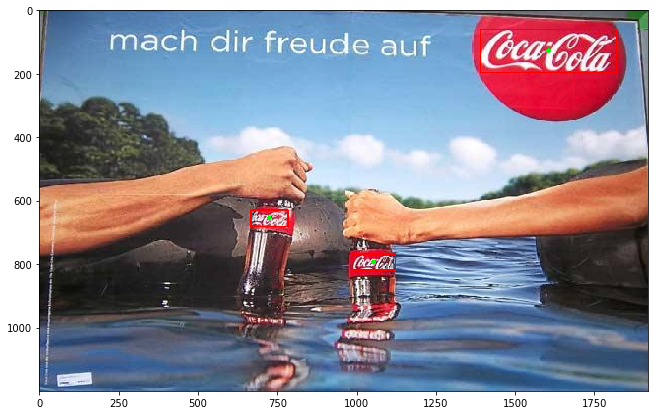

In [78]:
im_name = '000000.jpg'
img = cv2.imread('cleaned_imgs_v4/' + im_name)
frame_np = np.array(frames[im_name])
draw_img = draw_boxes(img, frame_np[:,0], draw_dot=True)
cv2.imwrite('bboxes.jpg', draw_img)
plt.figure(figsize=(12,7))
plt.imshow(draw_img[:,:,::-1])

Overlay grid:

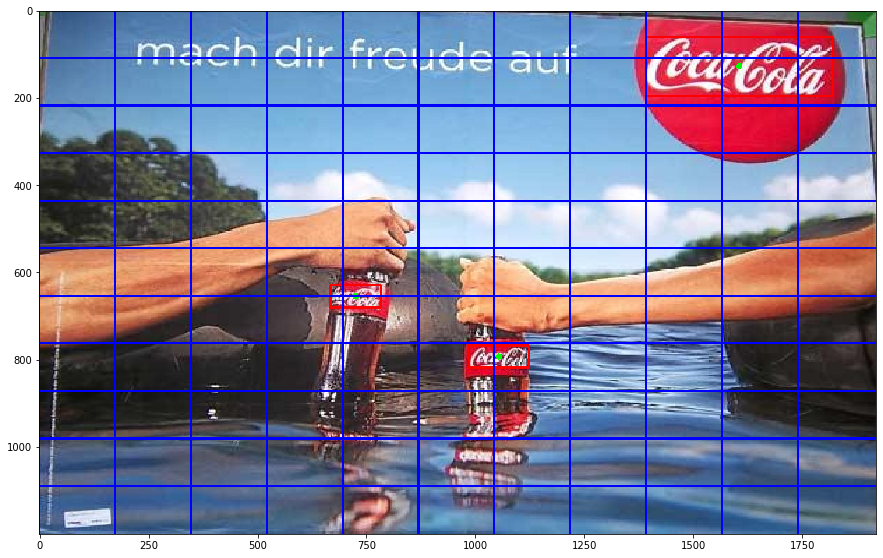

In [79]:
draw_img = draw_grid(draw_img)
cv2.imwrite('bboxes_grid.jpg', draw_img)
plt.figure(figsize=(15,30))
plt.imshow(draw_img[:,:,::-1])

### Visualize augumented and scaled images: ###

[(((162, 11), (212, 36)), (1, 0, 0)), (((114, 143), (131, 152)), (1, 0, 0)), (((77, 117), (91, 127)), (1, 0, 0))]
adjusted SV: 1.4810857033650788, 0.6320158551725377


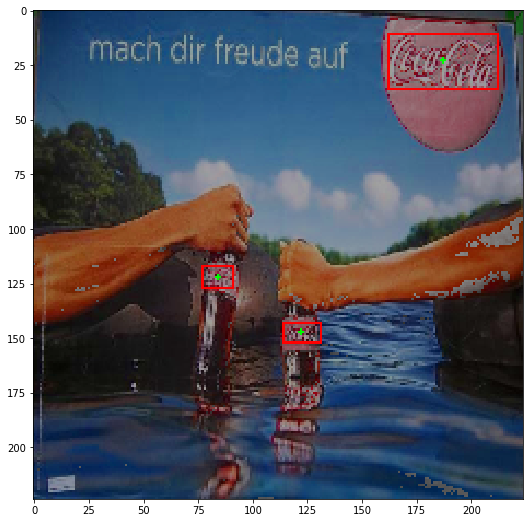

In [82]:
im_name = '000000.jpg'
print(frames_scaled[im_name])
img2 = cv2.imread('cleaned_imgs_v3/' + im_name)
img2 = cv2.resize(img2, (224,224))
img2, frame_np = augument_data(im_name, frames_scaled[im_name])
draw_img2 = draw_boxes(img2, np.array(frame_np)[:,0], thick=1, draw_dot=True, radius=1)
plt.figure(figsize=(15,9))
plt.imshow(draw_img2[:,:,::-1])

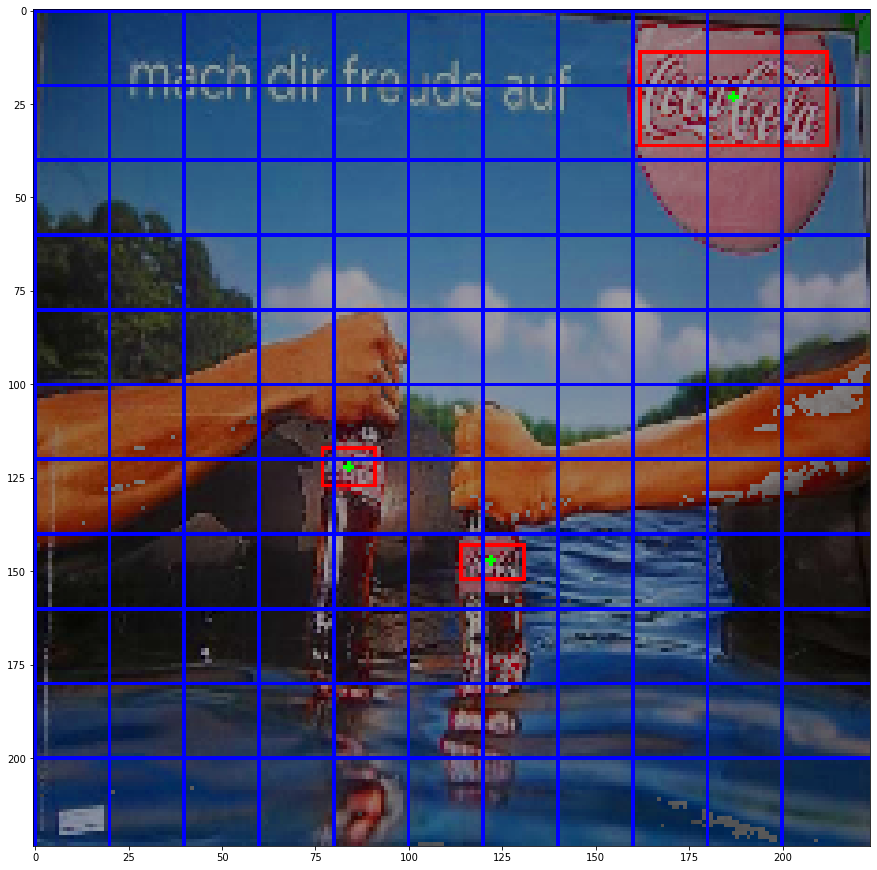

In [83]:
draw_img2 = draw_grid(draw_img2, thick=1)
plt.figure(figsize=(15,30))
plt.imshow(draw_img2[:,:,::-1])

## Test conversion to 1D array ##

In [85]:
grid, tensor = label_to_tensor(frames_scaled[im_name], gridsize=(11,11) )

In [86]:
grid

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [87]:
tensor.shape

(968,)

In [88]:
np.average(tensor)

0.005444307113341205

In [89]:
label_tensors = {}
for frame in frames_scaled:
    _, tensor = label_to_tensor(frames_scaled[frame])
    print(frame)
    label_tensors[frame] = tensor


000000.jpg
000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg
000011.jpg
000012.jpg
000014.jpg
000015.jpg
000016.jpg
000017.jpg
000018.jpg
000019.jpg
000020.jpg
000021.jpg
000022.jpg
000023.jpg
000024.jpg
000025.jpg
000026.jpg
000027.jpg
000028.jpg
000029.jpg
000030.jpg
000031.jpg
000032.jpg
000033.jpg
000034.jpg
000035.jpg
000036.jpg
000037.jpg
000038.jpg
000039.jpg
000040.jpg
000043.jpg
000044.jpg
000045.jpg
000047.jpg
000048.jpg
000049.jpg
000050.jpg
000051.jpg
000052.jpg
000053.jpg
000054.jpg
000055.jpg
000056.jpg
000057.jpg
000058.jpg
000059.jpg
000060.jpg
000061.jpg
000064.jpg
000065.jpg
000066.jpg
000068.jpg
000070.jpg
000071.jpg
000072.jpg
000073.jpg
000074.jpg
000075.jpg
000076.jpg
000077.jpg
000078.jpg
000079.jpg
000080.jpg
000081.jpg
000082.jpg
000084.jpg
000085.jpg
000086.jpg
000087.jpg
000088.jpg
000089.jpg
000090.jpg
000091.jpg
000092.jpg
000093.jpg
000095.jpg
000096.jpg
000097.jpg
000098.jpg
000099.jpg
000100.jpg
000101.jpg

In [90]:
len(label_tensors)

764

In [91]:
with open('label_tensors_logosIW3.p', 'wb') as f:
    pickle.dump(label_tensors, f)

In [92]:
with open('label_frames_logosIW3.p', 'wb') as f:
    pickle.dump(frames_scaled, f)

In [93]:
len(frames_scaled)

764